<a href="https://colab.research.google.com/github/yuuuwoo/Video_tracking788/blob/main/Report3_test_yolov3(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quick implement with yolov3


Use YOLO to detect\
Adjust annotation\
Fit into model\
Predict\
Evaluate

#Install package 

##Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
# read costumized file path
%cd mydrive/MyDrive/Colab_Notebooks/SEP788GP3/
!ls

/content/mydrive/MyDrive/Colab_Notebooks/SEP788GP3
 256px-Cars_in_traffic_in_Auckland,_New_Zealand_-_copyright-free_photo_released_to_public_domain.jpeg
 Autonomous+driving+application+-+Car+detection+-+v3.ipynb
 BlurCar1_0248.jpg.txt
 coco.names
'Copy of Mount_Google_Drive.ipynb'
 Database
 Report1.ipynb
 Report3.ipynb
'sep788 presentation.gslides'
 yolov3.cfg
 yolov3.ipynb
 yolov3.weights
 yolov5original.ipynb


##Import

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline
import glob

#Data Preprocess

##Read data 

In [ ]:
def load_images_from_folder(image_folder):
  images = []
  images_filename = []
  lst = os.listdir(image_folder)
  lst.sort()

  for file in lst:
        img = plt.imread(os.path.join(image_folder,file))
        if img is not None:
            images.append(img)
            images_filename.append(file)
            w = img.shape[0]
            h = img.shape[1]
        
  return images, images_filename, w, h

In [ ]:
from pandas._libs import index
#blur car number#
label_folder = './Database/BlurCar1/groundtruth_rect.txt'
image_folder = './Database/BlurCar1/img'

#Read from annoations txt
head = ['x', 'y', 'box_width', 'box_length']
labeldata = pd.read_csv(label_folder, sep= '\s+', names = head)
labeldata['x_center']= np.nan
labeldata['y_center']= np.nan

#read from coco.name, 'car' = index '2'
classes = []
with open("./coco.names", "r") as f:
    classes = f.read().splitlines()

#Read image 
images, images_filename,w , h = load_images_from_folder(image_folder)
imagedata = pd.DataFrame(images_filename, columns=['filename'])

#caculate x_center and y_center for fitting into YOLO, normalize with image size

x_center = []
y_center = []
for i in range(len(imagedata)):
  x = labeldata.iloc[i,0]
  y = labeldata.iloc[i,1]
  width = labeldata.iloc[i,2]
  height = labeldata.iloc[i,3]
  x_cen = (x + width)/2
  y_cen = (y + height)/2
  #write normalized 
  labeldata.iloc[i,4] = x_cen/w
  labeldata.iloc[i,5] = y_cen/h
  labeldata.iloc[i,2] = width/w
  labeldata.iloc[i,3] = height/h

#save to dataframe
df = labeldata.join(imagedata)
df = df[['x_center', 'y_center','box_width','box_length', 'filename']]
df.head()


,x_center,y_center,box_width,box_length,filename
0,0.370833,0.213281,0.220833,0.164062,0247.jpg
1,0.369792,0.215625,0.220833,0.165625,0248.jpg
2,0.362500,0.222656,0.225000,0.165625,0249.jpg
3,0.343750,0.235937,0.222917,0.173437,0250.jpg
4,0.341667,0.245312,0.241667,0.164062,0251.jpg


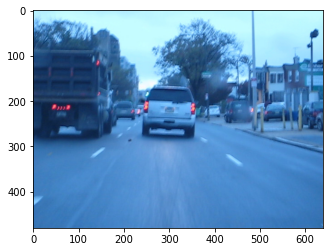

In [ ]:
img = plt.imread('/content/mydrive/MyDrive/Colab_Notebooks/SEP788GP3/Database/BlurCar1/img/0248.jpg')
plt.imshow(img)

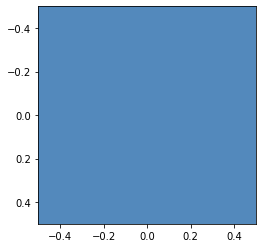

In [ ]:
from PIL import Image
imgs = Image.open('/content/mydrive/MyDrive/Colab_Notebooks/SEP788GP3/Database/BlurCar1/img/0248.jpg')

imgs = imgs.resize((1, 1))
plt.imshow(np.array(imgs))

#write label to txt

In [ ]:

location = './Database/Annotation/'
os.makedirs(location,exist_ok=True)
row_id = df.index.tolist()
for i in row_id:
  name = df.iloc[i].filename
  if name is not None:
    path = os.path.join(location, ('BlurCar1_' + str(name[:-4]) +  '.txt'))
  
    with open(path, "w+") as f:
      f.write(str(2) + ' '+ str(df.iloc[i,0]) + ' ' + str(df.iloc[i,1])+ ' ' + str(df.iloc[i,2])+ ' ' + str(df.iloc[i,3]))#seperator: '\s+'

In [ ]:
row_id = df.index.tolist()
for i in row_id:
  name = df.iloc[row_id].filename
print(str(name))

0      0247.jpg
1      0248.jpg
2      0249.jpg
3      0250.jpg
4      0251.jpg
         ...   
737    0984.jpg
738    0985.jpg
739    0986.jpg
740    0987.jpg
741    0988.jpg
Name: filename, Length: 742, dtype: object


#YOLO

In [ ]:
net = cv2.dnn.readNet('/content/MyDrive/MyDrive/Colab_Notebooks/SEP788GP3/yolov3.weights',
                      '/content/MyDrive/MyDrive/Colab_Notebooks/SEP788GP3/yolov3.cfg')

In [ ]:
classes = []
with open("/content/MyDrive/MyDrive/Colab_Notebooks/SEP788GP3/coco.names", "r") as f:
    classes = f.read().splitlines()

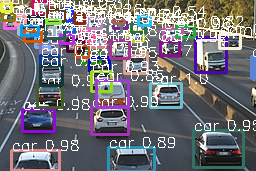

In [ ]:

colors = np.random.uniform(0, 255, size=(100, 3))
##quick test with random image 
path = '/content/MyDrive/MyDrive/Colab_Notebooks/SEP788GP3/256px-Cars_in_traffic_in_Auckland,_New_Zealand_-_copyright-free_photo_released_to_public_domain.jpeg'
while True:
    img = cv2.imread(path)
    height, width, _ = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    output_layers_names = net.getUnconnectedOutLayersNames()
    layerOutputs = net.forward(output_layers_names)

    boxes = []
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0]*width)
                center_y = int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

                x = int(center_x - w/2)
                y = int(center_y - h/2)

                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

    if len(indexes)>0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = colors[i]
            cv2.rectangle(img, (x,y), (x+w, y+h), color, 2)
            cv2.putText(img, label + " " + confidence, (x, y), 0, 0.5, (255,255,255))
    cv2_imshow(img)
    break

    


#cap.release()
#cv2.destroyAllWindows()